## Dataset Lig-SiO2: ponta revestida com lignina e substrato de dióxido de silício
### Teste 1 - 3x3, `grid_eight`, 100 séries temporais aleatórias.
### Importando bibliotecas e dados

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matrixprofile import matrixProfile, motifs
from pyclustering.nnet.som import type_conn
import math
import random
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))
import dtwsom

In [2]:
D3011_data = np.load('dataset_TipLig_SiO2.npz')

In [3]:
D3011_data.keys()

KeysView(NpzFile 'dataset_TipLig_SiO2.npz' with keys: verticalTipPosition_m, vDeflection_N, height_m, smoothedMeasuredHeight_m, measuredHeight_m...)

In [4]:
list(D3011_data.keys())

['verticalTipPosition_m',
 'vDeflection_N',
 'height_m',
 'smoothedMeasuredHeight_m',
 'measuredHeight_m',
 'seriesTime_s',
 'time_s']

In [5]:
force_data = D3011_data['vDeflection_N']

In [6]:
force_data.shape

(1024, 800)

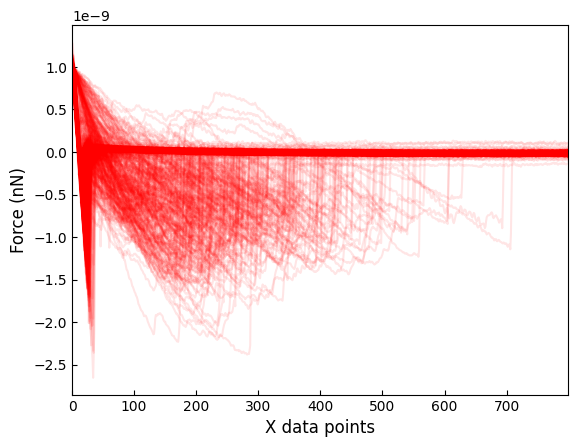

In [7]:
fig,ax = plt.subplots(dpi=100)

for curve in force_data:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,force_data.shape[1]-1])

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

### Split dos dados

Para essa clusterização, foram selecionados as **primeiras 100 curvas** do *dataset*.

In [8]:
random.seed(1025)
random.shuffle(force_data)

In [9]:
train_set = force_data[:100]
test_set = force_data[100:]

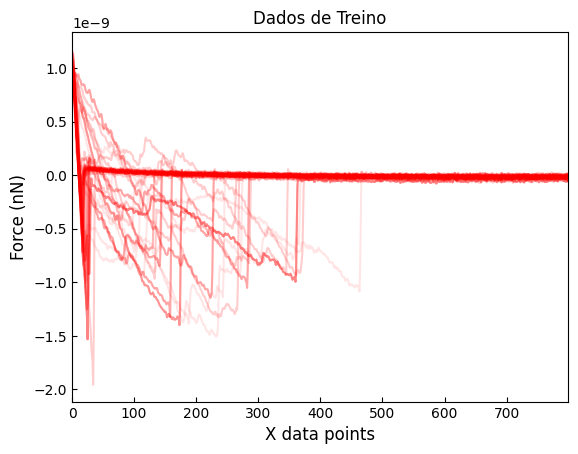

In [10]:
fig,ax = plt.subplots(dpi=100)

for curve in train_set:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,force_data.shape[1]-1])

ax.set_title("Dados de Treino")

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

In [11]:
len(train_set[0])

800

### Concatenando os dados e descobrindo motifs
Todas as curvas foram concatenadas em uma única série temporal, como indicado no artigo de base, do desenvolvimento do método DTW-SOM.

In [12]:
size = len(train_set[0])
sample_size = len(train_set)
print(size, sample_size)

800 100


In [13]:
joined_data = train_set[0]
for i in range(1, sample_size):
    joined_data = np.concatenate((joined_data, train_set[i]))
len(joined_data)

80000

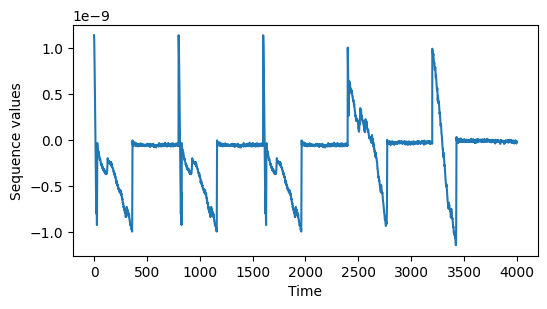

In [14]:
plt.figure(figsize=(6,3))
plt.plot(np.arange(4000), joined_data[:4000])
plt.ylabel("Sequence values")
plt.xlabel("Time")
plt.show()

In [15]:
%%time
mp = matrixProfile.stomp(joined_data, size)

CPU times: user 52.2 s, sys: 15 s, total: 1min 7s
Wall time: 1min 7s


In [16]:
print(mp[1])

[ 4800.   801.   802. ... 31998. 31999. 32000.]


Somando uma matriz de zeros à matriz de perfil, assim, os valores de `Nan` se tornam numéricos e iguais a zero.

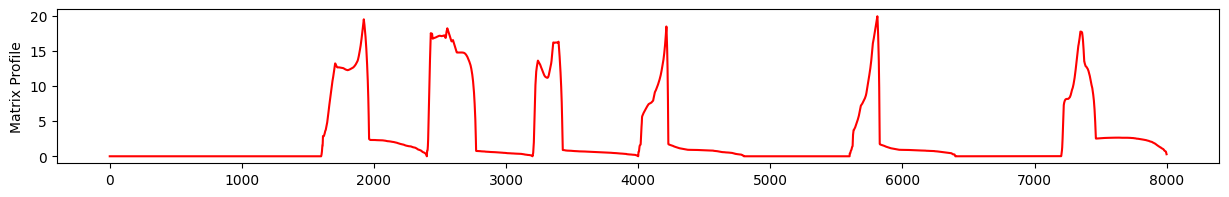

In [17]:
mp_adj = np.append(mp[0],np.zeros(size-1)+np.nan)

plt.figure(figsize=(15,2))
plt.plot(np.arange(8000), mp_adj[:8000], color='red')
plt.ylabel("Matrix Profile")
plt.show()

Extraindo os motifs.

In [18]:
%%time
mtfs, motif_d  = motifs.motifs(joined_data, mp, max_motifs=1000)
len(mtfs)

CPU times: user 266 ms, sys: 105 ms, total: 370 ms
Wall time: 320 ms


45

Criando uma lista com os centros de motifs.

In [19]:
motif_center_list = []
for motif in mtfs:
    center_pointers = list(np.arange(motif[0], motif[0]+size))
    motif_center = joined_data[center_pointers]
    motif_center_list.append(motif_center)

len(joined_data)

80000

In [20]:
len(motif_center_list)

45

### Treinando a rede DTW-SOM

In [21]:
%time
rows = 3
cols = 3
structure = type_conn.grid_eight
network = dtwsom.DtwSom(rows, cols, structure)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


In [22]:
%%time
network.train(motif_center_list, 50)

Epoch 1 achieved an average quantization error of 0.0
Epoch 2 achieved an average quantization error of 0.0
Epoch 3 achieved an average quantization error of 0.0
Epoch 4 achieved an average quantization error of 0.0
Epoch 5 achieved an average quantization error of 0.0
Epoch 6 achieved an average quantization error of 0.0
Epoch 7 achieved an average quantization error of 0.0
Epoch 8 achieved an average quantization error of 0.0
Epoch 9 achieved an average quantization error of 0.0
Epoch 10 achieved an average quantization error of 0.0
Epoch 11 achieved an average quantization error of 0.0
Epoch 12 achieved an average quantization error of 0.0
Epoch 13 achieved an average quantization error of 0.0
Epoch 14 achieved an average quantization error of 0.0
Epoch 15 achieved an average quantization error of 0.0
Epoch 16 achieved an average quantization error of 0.0
Epoch 17 achieved an average quantization error of 0.0
Epoch 18 achieved an average quantization error of 0.0
Epoch 19 achieved a

50

### Resultados

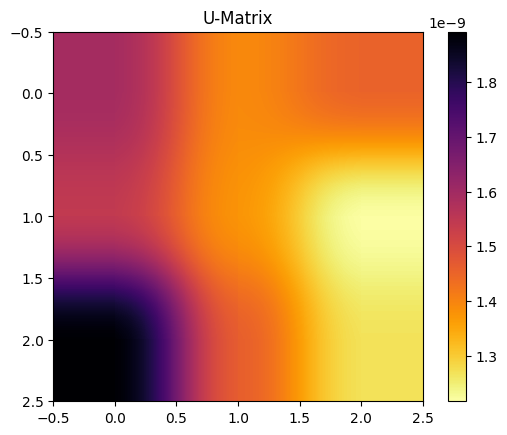

In [23]:
network.show_distance_matrix()

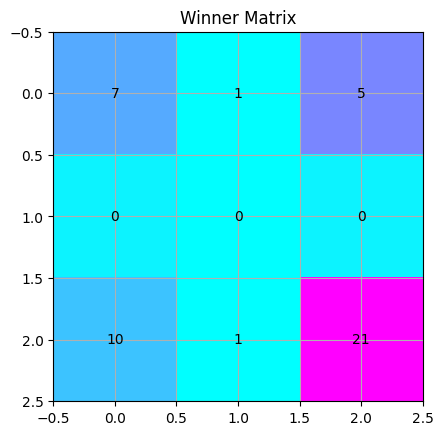

In [24]:
network.show_winner_matrix()

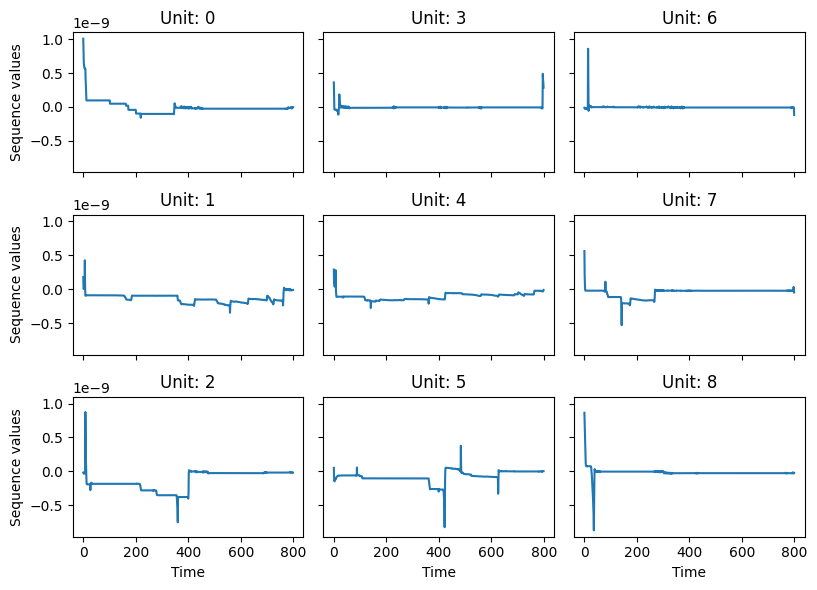

In [25]:
n_neurons = network._size
fig, axs = plt.subplots(3,3,figsize=(8, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/3) # round numbers down to the nearest integer:
    #math.ceil: round a number UP to the nearest integer
    row = neuron_index % 3
    neuron_weights = network._weights[neuron_index]
    axs[row, col].plot(np.arange(len(neuron_weights)), neuron_weights, label=str(neuron_index))
    axs[row, col].set_title("Unit: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Sequence values")
    if row == 2:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

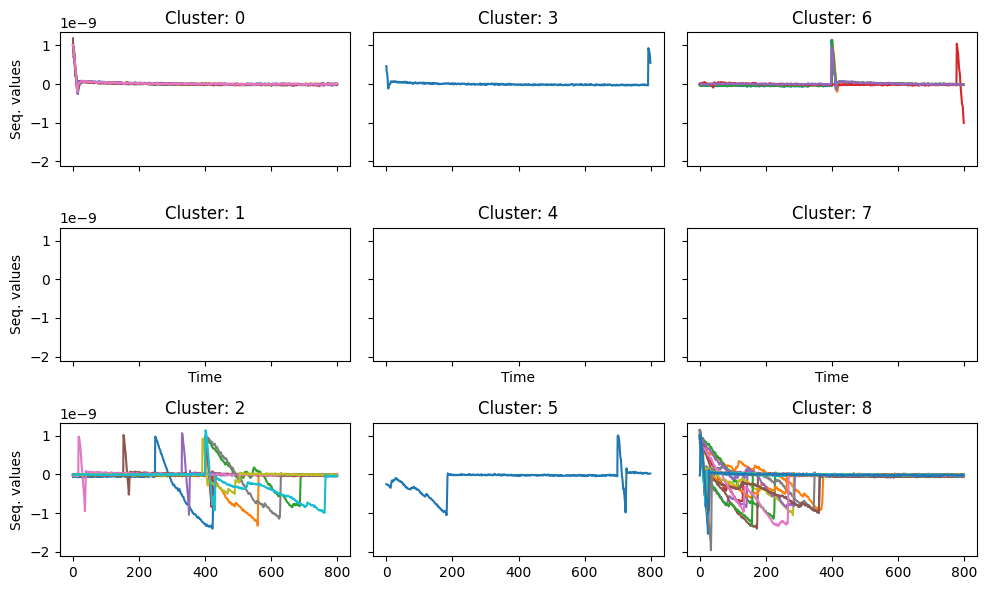

In [26]:
n = rows
n_neurons = network._size
fig, axs = plt.subplots(n,n,figsize=(10, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/n)
    row = neuron_index % n
    cluster_list = network.capture_objects[neuron_index]
    for member_index in cluster_list:
        axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
    axs[row, col].set_title("Cluster: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Seq. values")
    if row == 1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

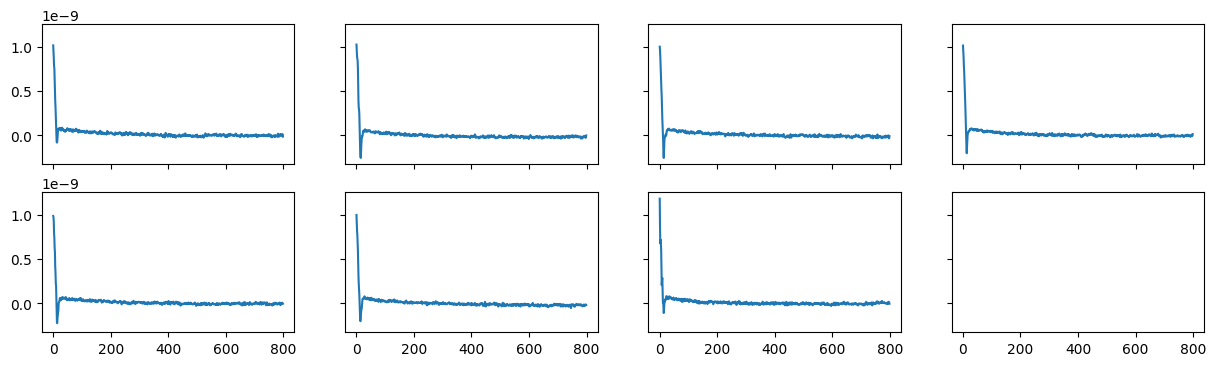

In [31]:
fig, axs = plt.subplots(2, 4,figsize=(15, 4), sharex=True, sharey=True)
cluster_list = network.capture_objects[0]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/2)
    row = i % 2
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

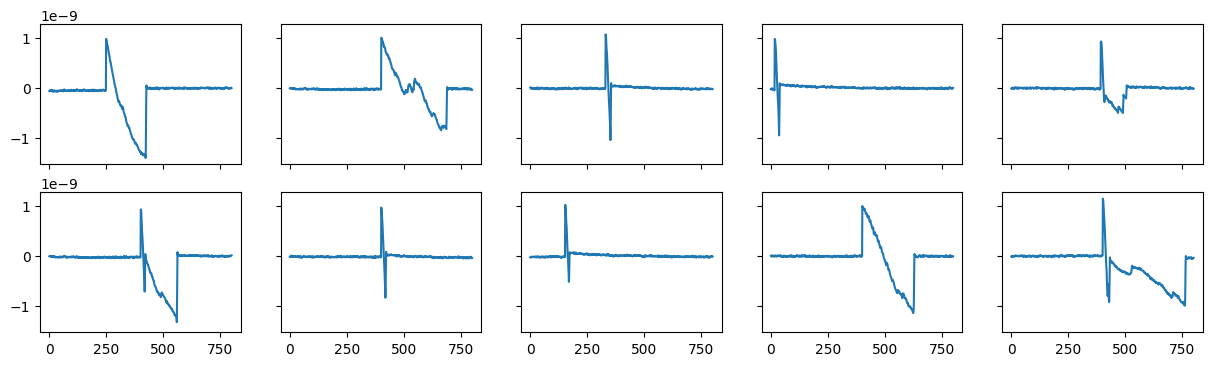

In [32]:
fig, axs = plt.subplots(2, 5,figsize=(15, 4), sharex=True, sharey=True)
cluster_list = network.capture_objects[2]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/2)
    row = i % 2
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

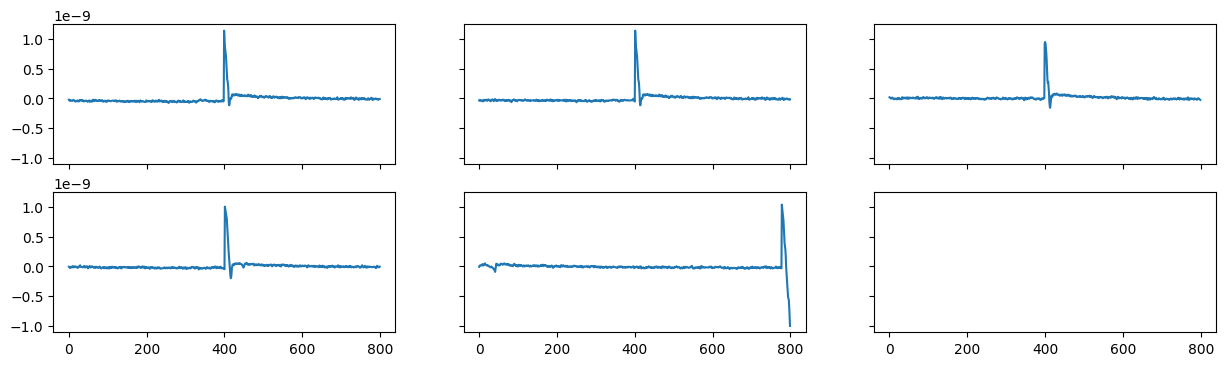

In [33]:
fig, axs = plt.subplots(2, 3,figsize=(15, 4), sharex=True, sharey=True)
cluster_list = network.capture_objects[6]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/2)
    row = i % 2
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

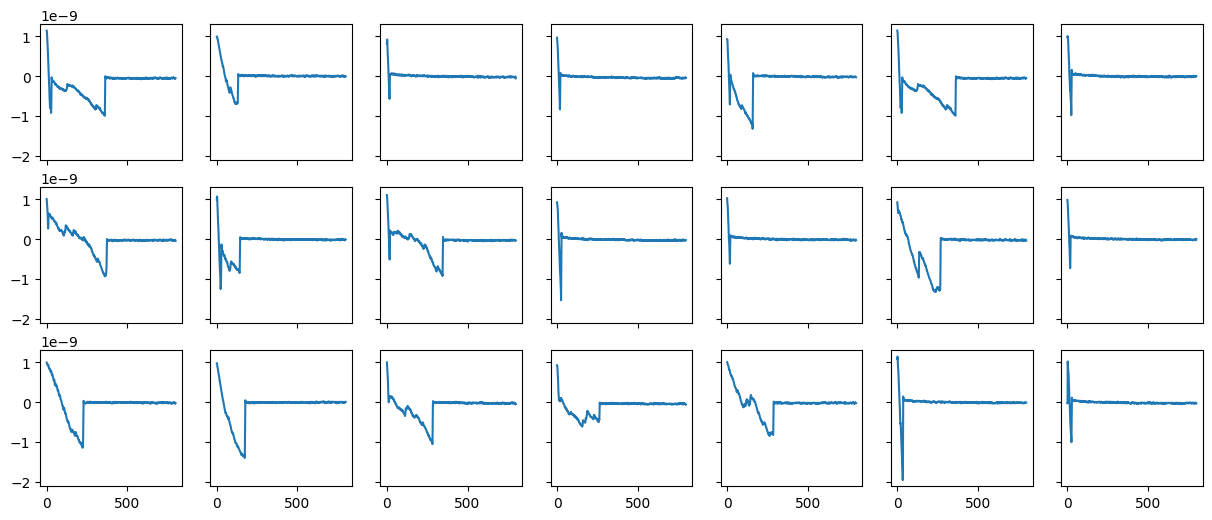

In [34]:
fig, axs = plt.subplots(3,7,figsize=(15, 6), sharex=True, sharey=True)
cluster_list = network.capture_objects[8]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/3)
    row = i % 3
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()